# Task2

# 0.데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML 
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy.linalg import inv 
import statsmodels.api as sm
df = pd.read_csv('Auction_master_train.csv',encoding='utf-8') 
## EDA에 필요한 라이브러리를 불러오고 오늘 필요한 data를 불러왔습니다. 

# 1. “1주차 과제”의 데이터를 가지고 선형회귀에 필요한 “EDA 및 전처리 및 인코딩”
- 범주형 변수 인코딩 3개 이상, EDA 3개 이상
- 1주차 과제 적극적으로 활용 가능 및 자신이 만든 Feature 역시 사용 가능

## 1.1 범주형 변수 인코딩 3개 이상, EDA 3개 이상 활용

먼저 추가한 변수에 대한 내용은 다음과 같습니다. 

#### 변수 추가
- auction_date / 경매일자	최종경매일 - 최초경매일
- skyscraper/ 초고층빌딩	초고층빌딩 = 1, 일반빌당 =0 (기준: 50층 이상)
- Royal_layer /로열층	로열층 = 1, 일반층 = 0 (기준: 30층이상)
- floor_rate / 건물 높이 비율	해당층/전체층수
- building_rate / 경매 건물 면적 비율	=총건물 경매 면적/총건물면적
- land_rate / 경매 토지 비율	=총 토지 경매면적/총 토지 실 면적
- Reconstruction / 재건축 프리미엄	보존등기를 기준으로 30년이상 = 1, 30년 미만 =0
- capital_gains /시세차익	도시별 평균가격과의 차이
- Expectation / 프리미엄 기대	감정가 < 낙찰가
- Attraction /매력도	1/(경매횟수+유찰횟수)

In [2]:
#1. auction_date 
## 경매소요일자/ 경매일자 최종경매일 - 최초경매일
df['auction_date']  = df['Final_auction_date'].astype('datetime64[ns]') - df['First_auction_date'].astype('datetime64[ns]')

#2. 초고층 빌딩의 여부 
## skyscraper/ 초고층빌딩 초고층빌딩 = 1, 일반빌당 =0 (기준: 50층 이상)
df["skyscraper"] = df["Total_floor"].apply(lambda x: 1 if x >= 50 else 0)

#3. 로열층의 여부
## Royal_layer /로열층 로열층 = 1, 일반층 = 0 (기준: 30층이상)
df["Royal_layer"] = df["Current_floor"].apply(lambda x: 1 if x >= 30 else 0)

#4. 건물 높이 비율
## floor_rate / 건물 높이 비율 해당층/전체층수
df["floor_rate"] = df['Current_floor'] / df['Total_floor']

#5. 경매건물 면적 비율
## building_rate / 경매 건물 면적 비율 =총건물 경매 면적/총건물면적
df["building_rate"] = df['Total_building_auction_area']/ df['Total_building_area']

#6. 경매토지 면적 비율
## land_rate / 경매 토지 비율 =총 토지 경매면적/총 토지 실 면적
df["land_rate"] = df['Total_land_auction_area']/ df['Total_land_gross_area'] 

#7. 재건축 프리미엄
## Reconstruction / 재건축 프리미엄 보존등기를 기준으로 30년이상 = 1, 30년 미만 =0
df['Reconstruction'] = 2020 - df["Preserve_regist_date"].str.slice(start=0, stop=4).astype('int')
df['Reconstruction'] = df["Reconstruction"].apply(lambda x: 1 if x >= 30 else 0)

#8. 시별 평균 가격과의 차이 
## capital_gains /시세차익 도시별 평균가격과의 차이
df['dong_mean'] = df.groupby(['addr_dong']).Hammer_price.transform('mean') #지역별 평균을 넣고
df['capital_gains'] = df['Hammer_price'] - df['dong_mean']

#9. 감정가보다 낙찰가가 높은 프리미엄
## Expectation / 프리미엄 기대 감정가 < 낙찰가
df['Expectation'] = df['Hammer_price' ] - df["Total_appraisal_price"]

#10. 매물의 인기도
## Attraction /매력도 1/(경매횟수+유찰횟수)
auctions_count = df['Auction_count'] - df['Auction_miscarriage_count']
df['Attraction'] = 1/ (df['Auction_count'] - df['Auction_miscarriage_count'])

일반적으로 건물의 면적이 크면 가격도 높아질 것이라고 생각하게 됩니다. 이러한 관계가 맞는지 그래프를 통하여 확인해 보도록 하겠습니다.


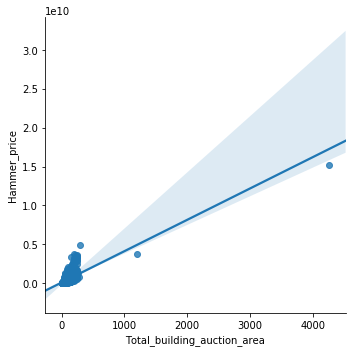

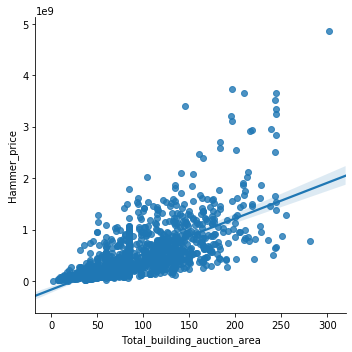

In [3]:
sns.lmplot(x='Total_building_auction_area',y='Hammer_price',data=df) #그래프가 그려졌지만 특정변수의 값이 너무 커서 그 관계를 자세하게 확인할 수 없었습니다. 

df2 = (df[df['Total_building_auction_area']<1000]) #따라서 건물 면적이 너무 클경우를 제외하고 다시 그래프를 그려보았습니다. 
sns.lmplot(x='Total_building_auction_area',y='Hammer_price',data=df2) #선형관계를 이루고 있는 것을 확인할 수 있었습니다.

In [4]:
df.head() #기존의 df에 10개의 feature을 추가한 내용에 대해서 5개만 추려봤을때의 정보를 확인할 수 있습니다.

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,skyscraper,Royal_layer,floor_rate,building_rate,land_rate,Reconstruction,dong_mean,capital_gains,Expectation,Attraction
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,0,0,0.111111,1.0,0.002966,0,9.440620e+08,-1.840620e+08,-76000000,1.0
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,1,1,0.728571,1.0,0.000442,0,9.440620e+08,2.782797e+07,-101110001,1.0
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,0,0,0.933333,1.0,0.000474,0,1.402298e+08,-4.682982e+07,-25600001,1.0
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,0,0,0.550000,1.0,0.001351,0,2.390215e+08,1.787746e+07,-31501000,1.0
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,0,0,1.000000,1.0,0.058372,0,1.482261e+08,1.043388e+07,-11340000,1.0


In [5]:
df.info() #데이터의 변수에 대한 설명이 나타나는데 간간히 범주형 변수가 보입니다. 필요한 변수인지 확인후에, 회귀분석을 위하여 인코딩하도록 하겠습니다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 52 columns):
Auction_key                    1933 non-null int64
Auction_class                  1933 non-null object
Bid_class                      1933 non-null object
Claim_price                    1933 non-null int64
Appraisal_company              1933 non-null object
Appraisal_date                 1933 non-null object
Auction_count                  1933 non-null int64
Auction_miscarriage_count      1933 non-null int64
Total_land_gross_area          1933 non-null float64
Total_land_real_area           1933 non-null float64
Total_land_auction_area        1933 non-null float64
Total_building_area            1933 non-null float64
Total_building_auction_area    1933 non-null float64
Total_appraisal_price          1933 non-null int64
Minimum_sales_price            1933 non-null int64
First_auction_date             1933 non-null object
Final_auction_date             1933 non-null object
Final_resu

### Share_auction_YorN
- 지분경매의 유무가 가격에 영향을 끼칠 수도 있다고 판단하여 인코딩하였습니다. 

In [6]:
df.Share_auction_YorN.value_counts()
#지분경매라면(Y) = 1, 그렇지 않다면(N) 0

N    1854
Y      79
Name: Share_auction_YorN, dtype: int64

In [7]:
def encoding (x):
    if x =='Y':
        return 1
    else:
        return 0

In [8]:
df.Share_auction_YorN = df.Share_auction_YorN.apply(encoding)

### Apartment_usage
- 건물의 구분이 아파트인지 주상복합인지에 따라 각종 세금문제에 영향을 끼치고 이는 가격에도 영향을 끼칠수도 있다고 판단하였습니다. 따라서 인코딩하였습니다.

In [9]:
df.Apartment_usage.value_counts()
#아파트면 0, 주상복합이면 1

아파트     1656
주상복합     277
Name: Apartment_usage, dtype: int64

In [10]:
def encoding (x):
    if x =='주상복합':
        return 1
    else:
        return 0

In [11]:
df.Apartment_usage = df.Apartment_usage.apply(encoding)

### Auction_class
- 경매의 유형이 지분경매인지 강제경매인지는 경매의 시작가격이나, 최종가격에 영향을 미칠 수 도 있다고 판단하여 인코딩작업을 진행하였습니다. 

In [12]:
# Auction_class
df.Auction_class.value_counts()
#임의라면 1, 강제라면 0

임의    1439
강제     494
Name: Auction_class, dtype: int64

In [13]:
def encoding (x):
    if x =='임의':
        return 1
    else:
        return 0

In [14]:
df.Auction_class = df.Auction_class.apply(encoding)

- 타겟변수를 중심으로 상관관계가 높은 변수들을 중심으로 전처리를 하도록 하겠습니다. 이를 위해 상관관게가 높은 변수순으로 절대값을 포함하여 0.2이상인 변수들만 추려내는 작업을 진행하였습니다. 

In [15]:
abs(df.corr()['Hammer_price']).sort_values()>0.2

addr_bunji1                    False
addr_bunji2                    False
Apartment_usage                False
floor_rate                     False
Auction_miscarriage_count      False
Auction_count                  False
road_bunji1                    False
Attraction                     False
land_rate                      False
Reconstruction                 False
Auction_class                  False
Total_land_gross_area          False
Share_auction_YorN             False
building_rate                  False
Current_floor                  False
road_bunji2                     True
skyscraper                      True
Total_floor                     True
Royal_layer                     True
Claim_price                     True
point.y                         True
point.x                         True
Auction_key                     True
Expectation                     True
capital_gains                   True
Total_land_real_area            True
Total_land_auction_area         True
d

- EDA라는 이름으로 위에서 0.2 이상인 변수들만 따로 지정하였습니다. 

In [16]:
EDA = df[['skyscraper','Total_floor','Royal_layer','Claim_price','Auction_key','Expectation','capital_gains','Total_land_real_area','Total_land_auction_area','dong_mean',
       'Total_building_area','Total_building_auction_area','Minimum_sales_price','Hammer_price']]
EDA.isnull().sum(axis=0)

skyscraper                     0
Total_floor                    0
Royal_layer                    0
Claim_price                    0
Auction_key                    0
Expectation                    0
capital_gains                  0
Total_land_real_area           0
Total_land_auction_area        0
dong_mean                      0
Total_building_area            0
Total_building_auction_area    0
Minimum_sales_price            0
Hammer_price                   0
dtype: int64

In [17]:
X = EDA.drop('Hammer_price', axis=1) #타겟변수만 제외
X.head()

,skyscraper,Total_floor,Royal_layer,Claim_price,Auction_key,Expectation,capital_gains,Total_land_real_area,Total_land_auction_area,dong_mean,Total_building_area,Total_building_auction_area,Minimum_sales_price
0,0,45,0,1766037301,2687,-76000000,-1.840620e+08,37.35,37.35,9.440620e+08,181.77,181.77,668800000
1,1,70,1,152946867,2577,-101110001,2.782797e+07,18.76,18.76,9.440620e+08,118.38,118.38,858400000
2,0,15,0,11326510,2197,-25600001,-4.682982e+07,71.00,71.00,1.402298e+08,49.94,49.94,76160000
3,0,20,0,183581724,2642,-31501000,1.787746e+07,32.98,32.98,2.390215e+08,84.91,84.91,230720000
4,0,7,0,45887671,1958,-11340000,1.043388e+07,45.18,45.18,1.482261e+08,84.96,84.96,136000000


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 이러한 변수들에 대해서 다중공선성을 확인해보도록 하겠습니다. 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
8,1335.361394,Total_land_auction_area
7,1322.580735,Total_land_real_area
11,1002.576184,Total_building_auction_area
10,996.843995,Total_building_area
12,188.172939,Minimum_sales_price
9,137.297850,dong_mean
6,54.011143,capital_gains
1,7.753700,Total_floor
5,7.170740,Expectation
4,4.709971,Auction_key


In [19]:
X.corr()

,skyscraper,Total_floor,Royal_layer,Claim_price,Auction_key,Expectation,capital_gains,Total_land_real_area,Total_land_auction_area,dong_mean,Total_building_area,Total_building_auction_area,Minimum_sales_price
skyscraper,1.000000,0.489148,0.532632,0.045426,0.040868,-0.070064,1.701850e-01,-0.022566,-0.021011,1.280745e-01,0.072981,0.074683,0.211715
Total_floor,0.489148,1.000000,0.569146,0.016466,0.142475,-0.034038,2.011875e-01,-0.072543,-0.068385,1.126687e-01,0.107069,0.108707,0.223407
Royal_layer,0.532632,0.569146,1.000000,0.049485,0.065712,-0.059989,1.847495e-01,-0.022727,-0.020728,1.424016e-01,0.096429,0.096557,0.235035
Claim_price,0.045426,0.016466,0.049485,1.000000,-0.136286,-0.152523,1.709994e-01,0.180421,0.182207,2.070646e-01,0.202379,0.204000,0.261076
Auction_key,0.040868,0.142475,0.065712,-0.136286,1.000000,0.067938,-5.382871e-03,-0.099446,-0.093441,-5.771811e-01,-0.126003,-0.117179,-0.403807
Expectation,-0.070064,-0.034038,-0.059989,-0.152523,0.067938,1.000000,-5.943796e-01,-0.898717,-0.898152,-3.036279e-01,-0.916278,-0.912631,-0.658967
capital_gains,0.170185,0.201187,0.184750,0.170999,-0.005383,-0.594380,1.000000e+00,0.632836,0.647500,9.281699e-17,0.675395,0.693840,0.699131
Total_land_real_area,-0.022566,-0.072543,-0.022727,0.180421,-0.099446,-0.898717,6.328363e-01,1.000000,0.996224,3.564523e-01,0.940361,0.934759,0.711515
Total_land_auction_area,-0.021011,-0.068385,-0.020728,0.182207,-0.093441,-0.898152,6.475002e-01,0.996224,1.000000,3.485941e-01,0.938144,0.941681,0.715891
dong_mean,0.128075,0.112669,0.142402,0.207065,-0.577181,-0.303628,9.281699e-17,0.356452,0.348594,1.000000e+00,0.415946,0.404216,0.707496


다중공선성을 확인해 봤을때 Total~ 과 관련한 변수들과 Minimum_sales_price이 매우높은 다중공선성을 나타내는 것을 확인할 수 있었습니다. 또한 아래와 같이 이러한 변수들의 상관관계와 다중공선성을 한번 변수를 제거하고 추가하는 것을 반복하여 확인해본 결과 이들은 서로 매우높은 상관관계를 띄는것을 알 수 있었습니다. 따라서 이러한 변수들을 제거하여 다시한번 확인해보도록 하겠습니다.  

In [20]:
X2 = X.drop(['Total_land_auction_area','Total_land_real_area','Total_building_auction_area','Total_building_area','Minimum_sales_price'],axis=1)

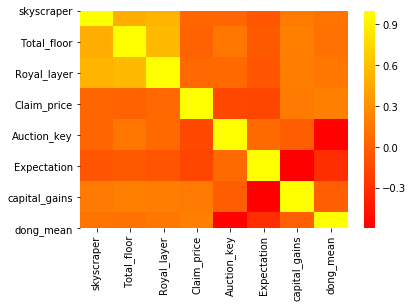

In [21]:
# Heatmap을 통해 확인해 봤을때서로 큰 상관관계를 갖지는 않는 것으로 나타났습니다. 
sns.heatmap(X2.corr(),cmap='autumn')
plt.show()

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
1,6.148541,Total_floor
4,3.217621,Auction_key
7,2.784810,dong_mean
5,1.896798,Expectation
6,1.866883,capital_gains
2,1.638549,Royal_layer
0,1.485262,skyscraper
3,1.162088,Claim_price


그 결과로 다중공선성이 10을 넘는 변수없이 안정적으로 출력되는 것을 확인할 수 있었습니다. 

In [23]:
Y = EDA.Hammer_price #타겟변수를 Y라는 이름으로 지정하였습니다. 

# 2. 선형회귀분석을 배웠으니 1주차 데이터를 다양한 방식으로 선형회귀분석! (Target: Hammer Price)
먼저 train, test data 을 분할하도록 0.8 : 0.2 비율로 분할하도록 하겠습니다. 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=0)

In [25]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train) 
# 모델을 불러오고 train set을 fit시켰습니다. 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
model.score(X_train, y_train)

1.0

fit한 모델의 경우 1로 출력되는데 아마 0.99... 가 반올림된것으로 추정됩니다. 

In [27]:
print(model.coef_) 
print(model.intercept_)
#회귀계수와 intercept은 다음과 같이 나타났습니다.

[-1.64860958e-06  2.05586821e-08  6.59963986e-07  3.33066907e-16
  4.81449671e-10  8.60422844e-16  1.00000000e+00  1.00000000e+00]
-1.3709068298339844e-06


In [28]:
model.predict(X_test) #모델을 가지고 test데이터 예측해보았습니다. 

array([4.02000000e+08, 7.45600000e+08, 1.38010000e+08, 2.95110000e+08,
       7.51600000e+08, 6.60000000e+07, 6.30418509e+08, 3.51700000e+08,
       1.05000000e+09, 4.28009900e+08, 6.37000000e+08, 1.96998895e+08,
       6.60000000e+08, 3.31000000e+08, 9.01230000e+07, 2.73333333e+08,
       8.60000000e+07, 1.33000000e+08, 8.03555555e+08, 1.20000000e+09,
       4.56670000e+08, 2.23755000e+08, 1.85200000e+09, 2.44440000e+08,
       1.35474000e+08, 1.40010000e+08, 5.81100000e+08, 9.36000100e+08,
       3.91222220e+08, 4.21488000e+07, 1.07401000e+09, 3.58000000e+08,
       2.92666000e+08, 7.00570000e+08, 5.49999999e+08, 3.02810000e+08,
       5.49990000e+08, 2.75599999e+08, 5.64299999e+08, 4.85217000e+08,
       8.82100000e+08, 4.05000000e+07, 3.13765000e+08, 2.31700000e+07,
       4.03010000e+08, 9.60000000e+08, 1.73711110e+08, 1.42769599e+09,
       4.20000000e+08, 3.28500000e+08, 8.31999000e+08, 1.07897000e+09,
       1.18400000e+08, 2.89800000e+08, 7.90000000e+08, 1.97000000e+08,
      

In [29]:
model.score(X_test, y_test)
#test데이터의 R-square 역시 1에 매우가깝게 나타났습니다.

1.0

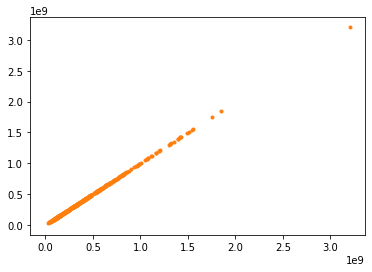

In [30]:
x = np.linspace(0, 330, 100)
y = x
y_pred = model.predict(X_test) 
plt.plot(x, y)
plt.plot(y_test, y_pred, '.')
plt.show()
#예상대로 매우 선형적으로 나타나고 있습니다. 

In [31]:
# 이러한 결과가 나타나게 되는데 가장 의심이 되는 capital_gains를 제외한뒤 re-trainning해보도록 하겠습니다. 
X3 = X2.drop(['capital_gains'],axis=1)

In [32]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif["features"] = X3.columns
vif.sort_values(["VIF Factor"], ascending=[False])
#다중공선성은 여전히 10미만으로 유지되고 있습니다. 

,VIF Factor,features
1,5.740060,Total_floor
4,3.131799,Auction_key
6,2.409433,dong_mean
2,1.634008,Royal_layer
0,1.484013,skyscraper
3,1.134505,Claim_price
5,1.110947,Expectation


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X3, Y, test_size=0.2, random_state=0)

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.7805690639460467

R-square가 0.78로 크게 떨어지는 것을 확인할 수 있었습니다. 

In [35]:
print(model.coef_) 
print(model.intercept_)

[ 2.75470715e+08  5.95217650e+06  2.19111370e+08  3.72135574e-02
 -7.35263825e+04 -8.25169648e-01  7.29330696e-01]
91273609.02749938


In [36]:
model.predict(X_test)

array([4.42072995e+08, 2.41417738e+09, 2.89642047e+08, 4.09947939e+08,
       5.45388507e+08, 1.69333248e+07, 5.98379670e+08, 3.84351447e+08,
       1.17940711e+09, 4.42498581e+08, 7.39122602e+08, 1.11919325e+08,
       6.13354726e+08, 3.98215542e+08, 2.79652651e+08, 1.17807395e+09,
       2.21509317e+08, 2.58463743e+08, 5.60111281e+08, 1.46215423e+09,
       5.34832529e+08, 3.56233971e+08, 1.22860011e+09, 3.39611905e+08,
       6.73731393e+08, 1.14899066e+08, 8.42982542e+08, 6.31177481e+08,
       3.46615278e+08, 1.36312983e+07, 1.08944805e+09, 3.29435716e+08,
       4.70785849e+08, 9.63376035e+08, 4.09222218e+09, 2.92609949e+08,
       5.05742644e+08, 2.78138513e+08, 2.71907407e+08, 4.59570491e+08,
       1.75110441e+09, 1.15281242e+08, 2.93907729e+08, 3.40437838e+07,
       7.33450016e+08, 1.07070687e+09, 1.21461964e+08, 6.16148264e+08,
       1.21740576e+09, 3.91051854e+08, 6.98657477e+08, 9.10529690e+08,
       2.84305788e+08, 2.83241957e+08, 1.01613578e+09, 1.91966854e+08,
      

# 3. 적합된 회귀식에 대해 데이터의 행렬을 통해 <Beta, MSE > 구하여 위의 값과 비교 (24-25참고)
- (3)번의 경우, sklearn을 사용하지 않고 행렬을 통해 값 추출하기

## 3.1 행렬을 통해 값 추출 하기 

In [37]:
def estimate_beta(x, y):
    x2 = np.transpose(x)
    x2x = np.dot(x2,x)
    x2y = np.dot(x2,y)
    x2x_inv = np.linalg.inv(x2x)
    beta_hat = np.dot(x2x_inv,x2y)
    
    return beta_hat
#Task1에서 작성한 함수를 불러왔습니다. 

In [38]:
a = np.array(X_train,dtype='i8')
b =  np.array(y_train,dtype='i8')
a = a.reshape((1546,7))
b = b.reshape((1546,1))
#a,b라는 이름으로 X_train과 y_train을 행렬로 만들어줍니다.

In [39]:
a2 = np.ones((1546,1),dtype='i8')
a2 = a2.reshape((1546,1))
a3 = np.concatenate((a2,a), axis=1)
#a2라는 이름으로 1로이루어진 행렬을 만들고 이를 a3이라는 이름으로 a와 합쳐주었습니다. 

In [40]:
estimate_beta(a3,b) #다음과 같이 beta가 출력되었습니다. 

array([[ 3.64315303e+07],
       [ 1.10927701e+09],
       [-5.19209033e+06],
       [ 8.78004865e+08],
       [-3.45667369e+00],
       [-2.60033146e+04],
       [-8.75197039e-01],
       [ 3.63671644e+00]])

In [41]:
reg = LinearRegression(fit_intercept=False).fit(a3, b)
reg.coef_  #회귀계수는 다음과 같습니다. 

array([[ 9.12735776e+07,  2.75470498e+08,  5.95217708e+06,
         2.19111433e+08,  3.72135937e-02, -7.35263841e+04,
        -8.25169582e-01,  7.29330689e-01]])

## 3.2 sklearn을 활용하여 값 추출하기 
sklearn을 활용하여 MSE를 확인하도록 하겠습니다. 

In [42]:
import sklearn as sk
sk.metrics.mean_squared_error(y_train, model.predict(X_train))
#다음과 같이 MSE가 매우 작게 나타나는 것을 알 수 있습니다. 

7.79337590185693e+16

In [43]:
X3.columns

Index(['skyscraper', 'Total_floor', 'Royal_layer', 'Claim_price',
       'Auction_key', 'Expectation', 'dong_mean'],
      dtype='object')

In [44]:
reg = sm.OLS.from_formula("Hammer_price ~ skyscraper + Total_floor + Royal_layer + Claim_price + Auction_key +Expectation+ dong_mean", df).fit()
reg.summary()
#R-squared는 74.5%로 나타났습니다. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     805.3
Date:                Tue, 28 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:46:39   Log-Likelihood:                -40348.
No. Observations:                1933   AIC:                         8.071e+04
Df Residuals:                    1925   BIC:                         8.076e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.359e+08   2.43e+07      5.590      0.000    8.82e+07    1.84e+08
skyscraper    1.78e+08    8.2e+07      2.171      0.030    1.72e+07    3.39e+08
Total_floor   7.31e+06   8.66e+05      8.438      0.000    5.61e+06    9.01e+06
Royal_layer  1.962e+08   5.32e+07      3.686      0.000    9.18e+07    3.01e+08
Claim_price     0.0324      0.005      6.576      0.000       0.023       0.042
Auction_key -9.333e+04   1.03e+04     -9.104      0.000   -1.13e+05   -7.32e+04
Expectation    -0.8397      0.022    -37.607      0.000      -0.883      -0.796
dong_mean       0.6392      0.022     29.630      0.000       0.597       0.682
==============================================================================
Omnibus:                      644.343   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81889.477
Skew:                           0.470   Prob(JB):                         0.00
Kurtosis:                      34.872   Cond. No.                     1.87e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""